In [1]:
import tensorflow as tf
import os,shutil
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout,Flatten, Dense 
np.set_printoptions(threshold=np.inf)
from tensorflow.keras import Model

In [2]:

original_dataset_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/train'
base_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/find_cats_and_dogs'
train_dir=os.path.join(base_dir,'train')

validation_dir=os.path.join(base_dir,'validaiton')

test_dir=os.path.join(base_dir,'test')


train_cats_dir = os.path.join(train_dir, 'cats')


train_dogs_dir = os.path.join(train_dir, 'dogs')


validation_cats_dir = os.path.join(validation_dir, 'cats')


validation_dogs_dir = os.path.join(validation_dir, 'dogs')


test_cats_dir = os.path.join(test_dir, 'cats')


test_dogs_dir = os.path.join(test_dir, 'dogs')




In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 3000
total training dog images: 3000
total validation cat images: 1000
total validation dog images: 1000
total test cat images: 1000
total test dog images: 1000


In [4]:
from keras.preprocessing.image import ImageDataGenerator
# 训练数据的增强
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # 目标目录
    target_size=(150,150),  # 大小调整
    batch_size=64,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=64,
    class_mode="binary"
)


Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
#数据增强处理
datagen = ImageDataGenerator(
    rotation_range=40,  # 0-180的角度值
    width_shift_range=0.2,  # 水平和垂直方向的范围；相对于总宽度或者高度的比例
    height_shift_range=0.2,
    shear_range=0.2,  # 随机错切变换的角度
    zoom_range=0.2,  # 图像随机缩放的角度
    horizontal_flip=True,  # 随机将一半图像进行水平翻转
    fill_mode="nearest"  # 用于填充新创建像素的方法
)

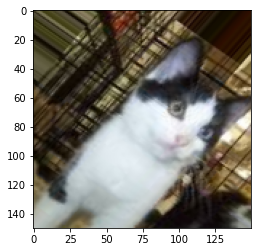

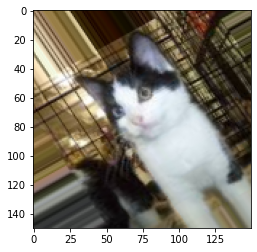

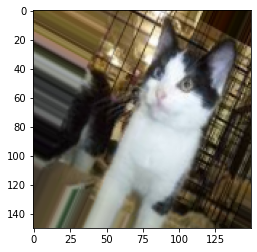

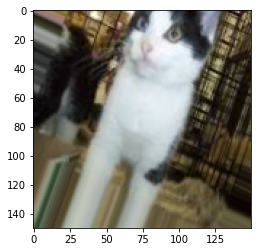

In [6]:
#数据增强
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[3]
# 读取图片并调整大小
img = image.load_img(img_path, target_size=(150,150))  
# 转成数组
x = image.img_to_array(img)

# shape转成(1,150,150,3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):  # 生成随机变换后的图像批量
    plt.figure()   
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break  # 循环是无限，需要在某个时刻终止
        
plt.show()

In [7]:
# from keras.preprocessing.image import ImageDataGenerator
# # 训练数据的增强
# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# # 不能增强验证数据
# test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# train_generator = train_datagen.flow_from_directory(
#     train_dir,  # 目标目录
#     target_size=(150,150),  # 大小调整
#     batch_size=64,
#     class_mode="binary"
# )

# validation_generator = test_datagen.flow_from_directory(
#     validation_dir,
#     target_size=(150,150),
#     batch_size=64,
#     class_mode="binary"
# )


Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


以上就是基本准备加数据增强，训练从下面开始

In [7]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,    # 是否包括全连接分类器，显然在ImageNet中有上千分类，在我们这里是不需要的
                  input_shape=(150, 150, 3))

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20


def extarct_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels


train_features, train_labels = extarct_features(train_dir, 6000)
validation_features, validation_labels = extarct_features(validation_dir, 2000)
test_features, test_labels = extarct_features(test_dir, 2000)

train_features = np.reshape(train_features, (6000, 4* 4 * 512))
validation_features = np.reshape(validation_features, (2000, 4* 4 * 512))
test_features = np.reshape(test_features, (2000, 4 * 4 * 512))

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
conv_base.trainable = False

In [11]:
from tensorflow.keras import regularizers

In [14]:
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu',input_dim=4 * 4 * 512,kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [15]:
#微调模型
conv_base.trainable=True
set_trainable=False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [17]:
checkpoint_save_path="./checkpoint/vgg16.ckpt"
if os.path.exists(checkpoint_save_path+'.index'):
    print("--------加载模型---------")
    model.load_weights(checkpoint_save_path)
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,
                                              save_best_only=True)

--------加载模型---------

Two checkpoint references resolved to different objects (<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000002073BEA6700> and <keras.layers.core.Dropout object at 0x0000020641CC9880>).


In [18]:
history=model.fit_generator(
      train_generator,
      steps_per_epoch=94,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=32,
    callbacks=[cp_callback])

D:\programming\Anaconda\envs\tensorflow2\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
94/94 [==============================] - 54s 529ms/step - loss: 0.2258 - acc: 0.9517 - val_loss: 0.2934 - val_acc: 0.9285
Epoch 2/50
94/94 [==============================] - 48s 511ms/step - loss: 0.1344 - acc: 0.9897 - val_loss: 0.2128 - val_acc: 0.9480
Epoch 3/50
94/94 [==============================] - 48s 513ms/step - loss: 0.1227 - acc: 0.9913 - val_loss: 0.2064 - val_acc: 0.9525
Epoch 4/50
94/94 [==============================] - 49s 516ms/step - loss: 0.1205 - acc: 0.9925 - val_loss: 0.2501 - val_acc: 0.9405
Epoch 5/50
94/94 [==============================] - 49s 516ms/step - loss: 0.1201 - acc: 0.9898 - val_loss: 0.2294 - val_acc: 0.9480
Epoch 6/50
94/94 [==============================] - 48s 513ms/step - loss: 0.1146 - acc: 0.9922 - val_loss: 0.2480 - val_acc: 0.9460
Epoch 7/50
94/94 [==============================] - 48s 511ms/step - loss: 0.1121 - acc: 0.9922 - val_loss: 0.2037 - val_acc: 0.9545
Epoch 8/50
94/94 [==============================] - 49s 515ms/step - 

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


Text(0.5, 1.0, 'Training and validation loss')

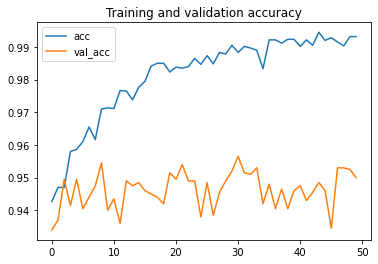

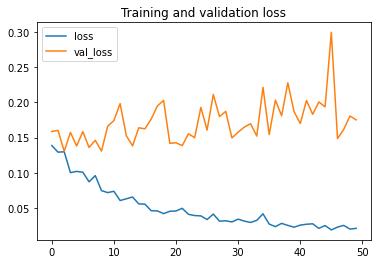

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))
plt.plot  ( epochs,     acc ,label='acc')
plt.plot  ( epochs, val_acc ,label='val_acc')
plt.legend(loc='best')
plt.title ('Training and validation accuracy')
plt.figure()
plt.plot  ( epochs,     loss ,label='loss')
plt.plot  ( epochs, val_loss ,label='val_loss')
plt.legend(loc='best')
plt.title ('Training and validation loss')


In [19]:
model.save("cats_and_dogs_vgg.h5")